In [49]:
from fastai.data.all import *
from fastai.vision.all import *
import torch
import ipywidgets as widgets
from fastai.vision.widgets import *

In [50]:
path = untar_data(URLs.MNIST)
path

Path('C:/Users/anupam/.fastai/data/mnist_png')

In [51]:
path.ls

<bound method Path.ls of Path('C:/Users/anupam/.fastai/data/mnist_png')>

In [52]:
train_images = get_files(path/'training', recurse=True, extensions=".png")
len(train_images)

60000

In [53]:
from nbdev import show_doc
show_doc(Path)

<h2 id="Path" class="doc_header"><code>class</code> <code>Path</code><a href="pathlib.py#L1021" class="source_link" style="float:right">[source]</a></h2>

> <code>Path</code>(**\*`args`**, **\*\*`kwargs`**) :: `PurePath`

PurePath subclass that can make system calls.

Path represents a filesystem path but unlike PurePath, also offers
methods to do system calls on path objects. Depending on your system,
instantiating a Path will return either a PosixPath or a WindowsPath
object. You can also instantiate a PosixPath or WindowsPath directly,
but cannot instantiate a WindowsPath on a POSIX system or vice versa.

In [54]:
test_images = get_image_files(path/'testing')
type(test_images)

fastcore.foundation.L

In [55]:
db_mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                    get_items=get_image_files,
                    splitter=GrandparentSplitter(train_name="training", valid_name="testing"),
                    get_y=parent_label)

In [56]:
# calculate the mean and std dev of training image data
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_train = [to_tensor(img) for img, label in db_mnist.datasets(path/'training')]
img_train_stack = torch.stack(img_train, dim=3)
img_train_stack_1d = img_train_stack.view(1, -1)
img_mean = img_train_stack_1d.mean(dim=1)
img_stdev = img_train_stack_1d.std(dim = 1)
print(f"Mean = {img_mean}, Std. dev. = {img_stdev}")

Mean = tensor([0.1307]), Std. dev. = tensor([0.3081])


In [57]:
# batc
norm_tfm = Normalize.from_stats(img_mean, img_stdev)
norm_tfm

Normalize -- {'mean': tensor([[[[0.1307]]]], device='cuda:0'), 'std': tensor([[[[0.3081]]]], device='cuda:0'), 'axes': (0, 2, 3)}:
encodes: (TensorImage,object) -> encodes
decodes: (TensorImage,object) -> decodes

# Multiple ways to add normalize transform

In [58]:
# Approach 1
# Create a data loader using helper function which internally make a call to DataBlock api
fnames = get_image_files(path)
def label_func(x): return x.parent.name
dl_mnist = ImageDataLoaders.from_path_func(path, fnames, label_func, seed=42, batch_tfms=norm_tfm)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [59]:
# Approach 2
# create a data block with the required transforms in place
db_mnist_norm = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                    get_items=get_image_files,
                    splitter=GrandparentSplitter(train_name="training", valid_name="testing"),
                    get_y=parent_label,
                    batch_tfms=norm_tfm)

In [ ]:
from torchvision import datasets

data_path = "./dataset"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize(img_mean, img_stdev)])

train_mnist = datasets.MNIST(data_path, train=True, download=False, transform = data_transform)
val_mnist = datasets.MNIST(data_path, train=False, download=False, transform=data_transform)
img_to_1d_tensor = Transform(lambda img: img.view(img.shape[0], -1))
#train_dl = TfmdDL(train_mnist, device=device, shuffle=True)
dls = DataLoaders.from_dsets(train_mnist, val_mnist, device=device)

In [62]:
# Approach 3
# Create a data loader from the previously created data block and add the transform to it
# Note that batch transforms are applied on the entire batch on gpu whereas
# item transforms are applied item wise on cpu before the batch is created ( transform like Resize ). 
dl_mnist_norm = DataLoaders(db_mnist.dataloaders(path))
dl_mnist_norm.add_tfms([norm_tfm], 'after_batch')
print(dl_mnist_norm.train.after_item)
print()
print(dl_mnist_norm.after_batch)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Pipeline: ToTensor

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.1307]]]], device='cuda:0'), 'std': tensor([[[[0.3081]]]], device='cuda:0'), 'axes': (0, 2, 3)}


In [ ]:
db_mnist_norm.summary(path)

In [ ]:
# the default transforms that appy on the mnist datablock
print(db_mnist.type_tfms)
print(db_mnist.default_item_tfms)
print(db_mnist.default_batch_tfms)

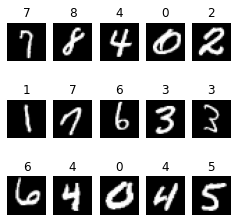

In [64]:
dl_mnist.show_batch(max_n=15, figsize=(4,4))